# LDA Model

In this document, I apply an LDA model to the pre-processed plot summaries and use coherence scores to optimise the hyperparameters. 


### Setup

In [36]:
import gensim
import pandas as pd
from nltk.tokenize import word_tokenize
import string
import nltk
import numpy as np
import re
import tqdm
from pprint import pprint# Gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
#import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel

### Importing the pre-processed plot summaries

To train the LDA model, we will use the output of file 04, which has already been tokenized and pre-processed for topic modelling.

In [40]:
stringed_data = pd.read_csv('./Data/stringed_plots.csv')
stringed_data[:5]

,Unnamed: 0,0
0,0,"['kaisa', 'scot', 'successful', 'london', 'law..."
1,1,"['plague', 'endless', 'jenny', 'suspect', 'chi..."
2,2,"['novel', 'young', 'nicotine', 'addict', 'trav..."
3,3,"['bronx', 'joe', 'sir', 'irish', 'good', 'guy'..."
4,4,"['county', 'durham', 'endless', 'violent', 'st..."


The below code converts the above from a pandas dataframe to a list of lists.

In [39]:
plots=[]
for i in range(0,len(stringed_data)):
    data=np.array(stringed_data.iloc[i])
    text=data[1]
    text=text.replace(',','')
    text=text.replace('[','')
    text=text.replace(']','')
    text=text.replace("'",'')
    tokens=word_tokenize(text)
    plots.append(tokens)
    
plots[:5]

[['kaisa',
  'scot',
  'successful',
  'london',
  'lawyer',
  'coke',
  'night',
  'stand',
  'aberdeen',
  'story',
  'begging',
  'fly',
  'collect',
  'alcoholic',
  'dad',
  'hasnt',
  'see',
  'impatient',
  'agree',
  'ruse',
  'mom',
  'dying',
  'want',
  'daughter',
  'trip',
  'get',
  'complicate',
  'drunk',
  'hot',
  'temper',
  'ban',
  'airline',
  'go',
  'ferry',
  'car',
  'need',
  'great',
  'deal',
  'help',
  'along',
  'way',
  'sweet',
  'lorry',
  'driver',
  'name',
  'clive',
  'reach',
  'death',
  'find',
  'stability'],
 ['plague',
  'endless',
  'jenny',
  'suspect',
  'child',
  'responsible',
  'brutal',
  'murder',
  'mother'],
 ['novel',
  'young',
  'nicotine',
  'addict',
  'traveler',
  'name',
  'richard',
  'avid',
  'pop',
  'culture',
  'buff',
  'particular',
  'love',
  'video',
  'vietnam',
  'war',
  'hotel',
  'bangkok',
  'map',
  'left',
  'strange',
  'whack',
  'commit',
  'suicide',
  'lead',
  'legendary',
  'island',
  'paradise',

### Building the LDA model

First we create the dictionary.

In [41]:
dictionary = gensim.corpora.Dictionary(plots)

count = 0
for k,v  in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
        
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
# gets rid of too common or uncommon words

0 aberdeen
1 agree
2 airline
3 alcoholic
4 along
5 ban
6 begging
7 car
8 clive
9 coke
10 collect


Next we make the corpus.

In [42]:
# Term Document Frequency 
corpus = [dictionary.doc2bow(text) for text in plots ]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)]]


Now we are ready to fit the model. At first I will just choose to try 10 topics to create a baseline.

In [43]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

The next code prints the top words in each topic. From this we can see some clear links between words in a topic, which sometimes appear to reflect a genre. For example, words like 'murder', 'killer', 'body' and 'survive' indicate that topic 5 may correspond to horror films. There are also many words in topic 6 (for example 'high', 'school', 'group') which indicate that this topic may be formed of words from plots of films aimed at teenagers, so the topics may help provide information on the target audience. 

In [44]:
pprint(lda_model.print_topics())

[(0,
  '0.025*"town" + 0.023*"man" + 0.022*"death" + 0.021*"daughter" + 0.021*"try" '
  '+ 0.018*"son" + 0.017*"father" + 0.016*"work" + 0.016*"small" + '
  '0.015*"run"'),
 (1,
  '0.052*"young" + 0.040*"story" + 0.031*"life" + 0.027*"woman" + '
  '0.024*"become" + 0.023*"begin" + 0.021*"love" + 0.019*"murder" + '
  '0.018*"relationship" + 0.016*"true"'),
 (2,
  '0.039*"house" + 0.025*"survive" + 0.023*"something" + 0.023*"everyone" + '
  '0.023*"middle" + 0.021*"girlfriend" + 0.020*"boyfriend" + 0.019*"desperate" '
  '+ 0.018*"party" + 0.017*"detective"'),
 (3,
  '0.047*"city" + 0.042*"mysterious" + 0.034*"york" + 0.029*"new" + '
  '0.021*"battle" + 0.018*"history" + 0.018*"deep" + 0.017*"confront" + '
  '0.017*"inspire" + 0.017*"create"'),
 (4,
  '0.068*"family" + 0.043*"take" + 0.028*"save" + 0.019*"struggle" + '
  '0.018*"order" + 0.017*"bring" + 0.016*"teenage" + 0.015*"fight" + '
  '0.014*"threaten" + 0.013*"place"'),
 (5,
  '0.035*"old" + 0.026*"year" + 0.024*"make" + 0.019*"get

We can make the topics easier to investigate using a visualisation.

In [45]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

C:\Users\user\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.251468 -0.049604       1        1  19.856077
5     -0.193332 -0.002538       2        1  12.978601
0     -0.103862  0.179476       3        1  12.660595
1     -0.180920  0.000242       4        1  11.576147
8     -0.006061 -0.198443       5        1  10.561614
4      0.124657  0.269912       6        1   9.371099
7      0.142707  0.172242       7        1   7.530399
2      0.178366 -0.092019       8        1   5.634163
3      0.112829 -0.189210       9        1   5.355952
6      0.177084 -0.090058      10        1   4.475355, topic_info=             Term         Freq        Total Category  logprob  loglift
163        family  1228.000000  1228.000000  Default  30.0000  30.0000
141         world  1098.000000  1098.000000  Default  29.0000  29.0000
67          young  1127.000000  1127.000000  Default  28.0000  28.0000
30          story   849.000000   849.000000  Default  27.0000  27.0000
279           new  1296.000000  1296.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1692  documentary    66.695992    67.858658  Topic10  -4.8154   3.0893
585      creative    65.865890    67.028618  Topic10  -4.8279   3.0891
411           rob    65.743827    66.906378  Topic10  -4.8298   3.0891
2181         blue    64.606507    65.769057  Topic10  -4.8472   3.0888
1717        state   102.027376   113.615327  Topic10  -4.3903   2.9990

[401 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2171      9  0.987255    academy
1665      8  0.986583     accept
956       5  0.995877     action
314      10  0.979678    actress
68        7  0.996637  adventure
...     ...       ...        ...
142       7  0.033678       year
1839      9  0.996346       york
67        1  0.005324      young
67        3  0.010647      young
67        4  0.983098      young

[467 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 1, 2, 9, 5, 8, 3, 4, 7])

We can see that many of the topics are overlapping, and topics 8 and 10, and 2 and 4 appear to be very similar, which indicates that it might be better to use fewer topics in the model.

### Hyperparameter optimisation

The LDA model has 3 hyperparameters that we can vary:
1. Number of Topics 
2. Dirichlet hyperparameter alpha: Document-Topic Density
3. Dirichlet hyperparameter beta: Word-Topic Density.

We will optimise these for our data by performing a series of sensitivity tests in sequence, one parameter at a time by keeping others constant. We will run these tests over the two different validation corpus sets for cross validation purposes.

We will use the coherence as a performance metric, which measures how often pairs of words appear together. In particular, we will use extrinsic coherence, c_v, which compares to standard reference documents, rather than intrinsic coherence, as our dataset is fairly small. 

First I compute a baseline coherence score using the model we already fitted.

In [46]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=plots, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.36824888697248614


The higher the coherence the better, so we will attempt to improve on this by tuning the hyperparameters.

In [10]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=plots, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

Since the visualisation shows that we should expect fewer topics to better represent the data, I chose to vary the number of topics between 3 and 10.

In [11]:
grid = {}
grid['Validation_Set'] = {}

# Topics values
min_topics = 3
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha values
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta values
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Cross validation 
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a while to run so I've saved the results for convenience
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./lda_tuning_results2.csv', index=False)
    pbar.close()

100%|██████████| 420/420 [10:36:58<00:00, 91.00s/it]     


In [47]:
optim_data = pd.read_csv('./Data/lda_tuning_results2.csv')
optim_data[:5]

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,3,0.01,0.01,0.418804
1,75% Corpus,3,0.01,0.31,0.396087
2,75% Corpus,3,0.01,0.61,0.390257
3,75% Corpus,3,0.01,0.9099999999999999,0.393643
4,75% Corpus,3,0.01,symmetric,0.392413


Let's investigate how the number of topics impacts the coherence. First we will just pick alpha = beta = 0.61 and visualise how the coherence varies by number of topics.

In [48]:
plot_data = optim_data.query("Alpha == '0.61' and Beta == '0.61' and Validation_Set == '100% Corpus'")
plot_data

,Validation_Set,Topics,Alpha,Beta,Coherence
222,100% Corpus,3,0.61,0.61,0.401157
252,100% Corpus,4,0.61,0.61,0.445390
282,100% Corpus,5,0.61,0.61,0.446564
312,100% Corpus,6,0.61,0.61,0.471923
342,100% Corpus,7,0.61,0.61,0.479433
372,100% Corpus,8,0.61,0.61,0.472385
402,100% Corpus,9,0.61,0.61,0.456210


<AxesSubplot:xlabel='Topics'>

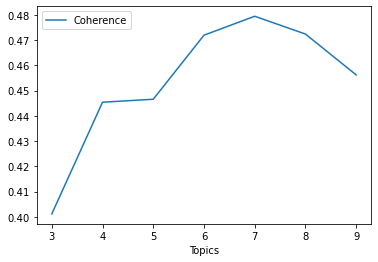

In [49]:
plot_data.plot.line(x='Topics', y='Coherence')


We can see that the coherence increases with number of topics until we reach 7, where the coherence begins to fall again, so 7 would be the best choice for the number of topics with these alpha and beta.

Now let's see which combination of factors increases the coherence the most.

In [50]:
max(optim_data.Coherence)

0.499681194035391

In [51]:
print(list(np.where(optim_data["Coherence"] == 0.499681194035391)))
print(list(np.where(optim_data["Coherence"] > 0.495)))

[array([407], dtype=int64)]
[array([149, 327, 407, 409], dtype=int64)]


In [16]:
optim_data[407:408]

,Validation_Set,Topics,Alpha,Beta,Coherence
407,100% Corpus,9,0.9099999999999999,0.61,0.499681


The highest coherence comes from the above parameters, but we have three other combinations which are very close.

In [17]:
optim_data[149:150]

,Validation_Set,Topics,Alpha,Beta,Coherence
149,75% Corpus,7,asymmetric,symmetric,0.497265


In [18]:
optim_data[327:328]

,Validation_Set,Topics,Alpha,Beta,Coherence
327,100% Corpus,6,asymmetric,0.61,0.498664


In [41]:
optim_data[409:410]

,Validation_Set,Topics,Alpha,Beta,Coherence
409,100% Corpus,9,0.9099999999999999,symmetric,0.495618


Optimising the hyperparamets has yielded an approximate 40% increase on the baseline coherence score, and we will now train the final model based on these hyperparameters.

In [52]:
lda_model_optim = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=9, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.9099999999999999,
                                           eta=0.61)

Next, lets's print the top ten words and visualise the new topics.

In [53]:
pprint(lda_model_optim.print_topics())

[(0,
  '0.030*"get" + 0.022*"go" + 0.011*"take" + 0.011*"job" + 0.010*"find" + '
  '0.010*"decide" + 0.010*"want" + 0.010*"day" + 0.008*"money" + 0.008*"help"'),
 (1,
  '0.022*"new" + 0.020*"woman" + 0.014*"york" + 0.011*"relationship" + '
  '0.009*"meet" + 0.009*"married" + 0.008*"wealthy" + 0.007*"business" + '
  '0.007*"work" + 0.007*"belief"'),
 (2,
  '0.026*"high" + 0.025*"school" + 0.021*"life" + 0.019*"girl" + 0.015*"begin" '
  '+ 0.012*"young" + 0.012*"college" + 0.012*"mysterious" + 0.012*"become" + '
  '0.010*"past"'),
 (3,
  '0.014*"war" + 0.013*"force" + 0.010*"world" + 0.010*"mission" + '
  '0.009*"team" + 0.008*"agent" + 0.008*"dangerous" + 0.008*"battle" + '
  '0.007*"powerful" + 0.007*"protect"'),
 (4,
  '0.036*"love" + 0.029*"life" + 0.015*"make" + 0.014*"struggle" + '
  '0.011*"family" + 0.011*"fall" + 0.011*"everything" + 0.009*"face" + '
  '0.009*"come" + 0.008*"beautiful"'),
 (5,
  '0.026*"old" + 0.022*"year" + 0.021*"family" + 0.018*"mother" + '
  '0.017*"daughter

In [22]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_optim, corpus, dictionary)
vis

C:\Users\user\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.034273  0.082294       1        1  11.951102
3      0.139589 -0.045965       2        1  11.799670
7      0.163636  0.000664       3        1  11.729035
5     -0.217453 -0.017632       4        1  11.675647
8     -0.048085  0.257852       5        1  11.006293
1     -0.142409 -0.080734       6        1  10.821288
6     -0.032758 -0.131758       7        1  10.705581
4      0.034553 -0.019989       8        1  10.479368
0      0.068654 -0.044730       9        1   9.832017, topic_info=            Term        Freq        Total Category  logprob  loglift
177       family  958.000000   958.000000  Default  30.0000  30.0000
30         story  754.000000   754.000000  Default  29.0000  29.0000
67         young  936.000000   936.000000  Default  28.0000  28.0000
515       school  567.000000   567.000000  Default  27.0000  27.0000
155        world  899.000000   899.000000  Default  26.0000  26.0000
...          ...         ...          ...      ...      ...      ...
1401        lost   86.707206   195.470437   Topic9  -5.3760   1.5067
294          new  125.986988  1235.732817   Topic9  -5.0024   0.0363
96         break   85.775046   254.821915   Topic9  -5.3868   1.2307
227   unexpected   79.128829   169.088056   Topic9  -5.4675   1.5602
691        group   87.747327   379.882871   Topic9  -5.3641   0.8541

[523 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
158       1  0.007677  accident
158       2  0.076766  accident
158       3  0.007677  accident
158       4  0.007677  accident
158       5  0.007677  accident
...     ...       ...       ...
1011      5  0.009062   younger
1011      6  0.009062   younger
1011      7  0.009062   younger
1011      8  0.009062   younger
1011      9  0.018125   younger

[3987 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 8, 6, 9, 2, 7, 5, 1])

These topics look quite different from the previous model, and we can see that we don't have quite as much overlap. Further, the topics 'make sense' intuitively, as for example we can see that we have one topic clearly linked to family, with words like 'family', 'son' and 'daugther', and another linked to crime, with words like 'murder', 'agent' and 'police'. Topic 5 in the visualisation contains mostly words linked to the film industry itself, such as 'true

### Outputting the results of LDA 

We now need to output the results of the LDA model as a vector for each plot summary to input into the boosted prediction model.

The below code grabs the distribution of the 9 topics for every plot summary, and we then check that the code has produced the correct number of vectors.
We use minimum_probability=0.0 in line 3 to ensure that we’ll capture the instances where a plot is represented as 0% in some topics, and the representation for each plot will add up to 100%.

In [54]:
train_vecs = []
for i in range(len(plots)):
    top_topics = (
        lda_model_optim.get_document_topics(corpus[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(9)]
    train_vecs.append(topic_vec)

train_vecs[:5]

[[0.5129505,
  0.114857286,
  0.023082444,
  0.024850568,
  0.032013923,
  0.0841311,
  0.06039946,
  0.04786142,
  0.09985328],
 [0.054330926,
  0.054314505,
  0.06180579,
  0.09514364,
  0.06805714,
  0.47711015,
  0.054116964,
  0.07790747,
  0.057213377],
 [0.03972124,
  0.23752728,
  0.038065787,
  0.08204335,
  0.07496352,
  0.0480328,
  0.21798746,
  0.2273355,
  0.034323078],
 [0.5139042,
  0.09889833,
  0.0424453,
  0.03445676,
  0.044801146,
  0.03966658,
  0.039551165,
  0.11883491,
  0.06744161],
 [0.044342846,
  0.04653146,
  0.028705044,
  0.027481917,
  0.29859418,
  0.19170946,
  0.1739034,
  0.026904471,
  0.16182725]]

In [55]:
len(train_vecs)

6514

I now convert this to a pandas dataframe and export.

In [56]:
output_df = pd.DataFrame(train_vecs, columns = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9'])
output_df[:5]

,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,0.512950,0.114857,0.023082,0.024851,0.032014,0.084131,0.060399,0.047861,0.099853
1,0.054331,0.054315,0.061806,0.095144,0.068057,0.477110,0.054117,0.077907,0.057213
2,0.039721,0.237527,0.038066,0.082043,0.074964,0.048033,0.217987,0.227335,0.034323
3,0.513904,0.098898,0.042445,0.034457,0.044801,0.039667,0.039551,0.118835,0.067442
4,0.044343,0.046531,0.028705,0.027482,0.298594,0.191709,0.173903,0.026904,0.161827


In [57]:
output_df.to_csv('./Data/LDA_topics.csv')

### Synonym extension

Here we briefly look at how using the synonym data impacts coherence.

In [58]:
synonym_stringed_data = pd.read_csv('./Data/synonym_stringed_plots.csv')

#convert to list of lists
s_plots=[]
for i in range(0,len(synonym_stringed_data)):
    data=np.array(synonym_stringed_data.iloc[i])
    text=data[1]
    text=text.replace(',','')
    text=text.replace('[','')
    text=text.replace(']','')
    text=text.replace("'",'')
    tokens=word_tokenize(text)
    s_plots.append(tokens)
    
s_plots[:5]

[['kaisa',
  'scot',
  'successful',
  'london',
  'lawyer',
  'snow',
  'night',
  'base',
  'aberdeen',
  'story',
  'begging',
  'flee',
  'collect',
  'alcoholic',
  'dad',
  'hasnt',
  'find',
  'impatient',
  'hold',
  'ruse',
  'mom',
  'break',
  'want',
  'daughter',
  'trip',
  'take',
  'complicate',
  'drunk',
  'live',
  'season',
  'ban',
  'airline',
  'get',
  'ferry',
  'car',
  'big',
  'care',
  'help',
  'along',
  'way',
  'fresh',
  'lorry',
  'driver',
  'make',
  'clive',
  'give',
  'end',
  'stability'],
 ['plague',
  'endless',
  'jenny',
  'suspect',
  'child',
  'responsible',
  'brutal',
  'murder',
  'mother'],
 ['novel',
  'young',
  'nicotine',
  'addict',
  'traveler',
  'make',
  'richard',
  'avid',
  'kill',
  'finish',
  'lover',
  'special',
  'love',
  'video',
  'vietnam',
  'war',
  'hotel',
  'bangkok',
  'map',
  'give',
  'strange',
  'whack',
  'place',
  'suicide',
  'lead',
  'legendary',
  'island',
  'paradise',
  'wayward',
  'someone'

In [59]:
s_dictionary = gensim.corpora.Dictionary(s_plots)

count = 0
for k,v  in s_dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
        
s_dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
# gets rid of too common or uncommon words

#corpus
s_corpus = [s_dictionary.doc2bow(text) for text in s_plots ]  

s_lda_model = gensim.models.LdaMulticore(corpus=s_corpus,
                                           id2word=s_dictionary,
                                           num_topics=9, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.9099999999999999,
                                           eta=0.61)

s_coherence_model_lda = CoherenceModel(model=s_lda_model, texts=s_plots, dictionary=s_dictionary, coherence='c_v')
s_coherence_lda = s_coherence_model_lda.get_coherence()
print('Coherence Score: ', s_coherence_lda)

0 aberdeen
1 airline
2 alcoholic
3 along
4 ban
5 base
6 begging
7 big
8 break
9 car
10 care
Coherence Score:  0.4771549697495909


Here we didn't optimise the parameters for the specific synonym model and the coherence is similar to (although slightly less than) the previous model. We can visualise the topics to see if they are different.

In [60]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(s_lda_model, s_corpus, s_dictionary)
vis

C:\Users\user\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.103999 -0.074606       1        1  12.920115
8      0.093027  0.064592       2        1  12.133856
2     -0.164844  0.066489       3        1  11.721036
0      0.115152  0.086403       4        1  10.929819
3     -0.027056 -0.211785       5        1  10.633042
6     -0.020381  0.033653       6        1  10.588419
4     -0.139668  0.121357       7        1  10.544959
7      0.163449  0.013992       8        1  10.533200
5     -0.123678 -0.100094       9        1   9.995554, topic_info=         Term         Freq        Total Category  logprob  loglift
30      story  1016.000000  1016.000000  Default  30.0000  30.0000
124       old  1027.000000  1027.000000  Default  29.0000  29.0000
161    family  1466.000000  1466.000000  Default  28.0000  28.0000
130    secret   764.000000   764.000000  Default  27.0000  27.0000
443    school   566.000000   566.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
192     force   114.578957   762.295391   Topic9  -5.0948   0.4080
166      life   124.221988  1833.495436   Topic9  -5.0140  -0.3889
332  struggle   105.653830   599.504124   Topic9  -5.1759   0.5671
640       run    99.621263   326.924346   Topic9  -5.2347   1.1147
371      head    99.374352   589.909999   Topic9  -5.2372   0.5220

[547 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
145       1  0.053471   able
145       2  0.802065   able
145       3  0.060155   able
145       4  0.006684   able
145       5  0.006684   able
...     ...       ...    ...
66        5  0.067936  young
66        6  0.088612  young
66        7  0.050214  young
66        8  0.095505  young
66        9  0.061044  young

[3933 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 9, 3, 1, 4, 7, 5, 8, 6])

The topics look farily similar to the previous model, as we can still see topics clearly related to war, murder and family. However it will still be an interesting exercise to see whether the synonym topics affect the prediction of IMDb differently so I export the results below.

### Outputting synonym LDA vectors

In [61]:
s_train_vecs = []
for i in range(len(s_plots)):
    top_topics = (
        s_lda_model.get_document_topics(s_corpus[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(9)]
    s_train_vecs.append(topic_vec)

s_train_vecs[:5]

[[0.07792434,
  0.10185415,
  0.04796862,
  0.06517677,
  0.028894616,
  0.06259126,
  0.12046321,
  0.14131704,
  0.35381004],
 [0.16384569,
  0.062530644,
  0.08382244,
  0.0575789,
  0.35493094,
  0.05449135,
  0.05894203,
  0.06234059,
  0.101517454],
 [0.03825455,
  0.040860143,
  0.12301228,
  0.15753974,
  0.075881824,
  0.097192116,
  0.19297527,
  0.0485531,
  0.22573097],
 [0.32873106,
  0.054867756,
  0.06352593,
  0.10823381,
  0.038529597,
  0.11762312,
  0.050714523,
  0.09863045,
  0.13914376],
 [0.18109496,
  0.20314628,
  0.1010261,
  0.21761914,
  0.04151371,
  0.0795147,
  0.037983257,
  0.10512091,
  0.03298093]]

In [62]:
len(s_train_vecs)

6514

In [63]:
s_output_df = pd.DataFrame(s_train_vecs, columns = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9'])
s_output_df[:5]

,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,0.077924,0.101854,0.047969,0.065177,0.028895,0.062591,0.120463,0.141317,0.353810
1,0.163846,0.062531,0.083822,0.057579,0.354931,0.054491,0.058942,0.062341,0.101517
2,0.038255,0.040860,0.123012,0.157540,0.075882,0.097192,0.192975,0.048553,0.225731
3,0.328731,0.054868,0.063526,0.108234,0.038530,0.117623,0.050715,0.098630,0.139144
4,0.181095,0.203146,0.101026,0.217619,0.041514,0.079515,0.037983,0.105121,0.032981


In [64]:
s_output_df.to_csv('./Data/LDA_topics_synonym.csv')

### References 

1. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0 
2. https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
3. https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920